In [1]:
import numpy as np
import pandas as pd

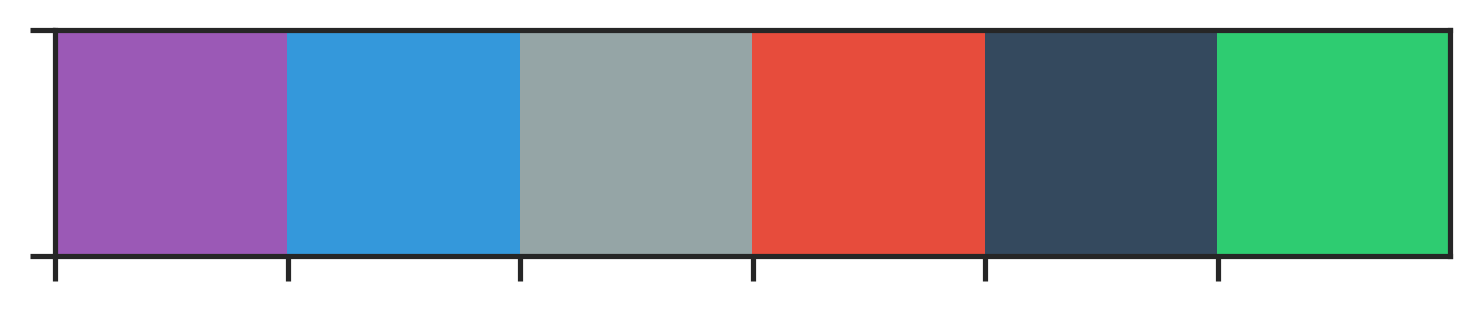

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
rc={'figure.dpi':300}
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style='ticks',rc=rc)
sns.color_palette(flatui)

In [4]:
# load data
sel_protein_df = pd.read_csv('f_data/train_norm_sel_protein_df_mi_108.csv', sep='\t')

In [5]:
# sel_lipid_df.shape[1]-2,sel_metabolic_df.shape[1]-2, sel_protein_df.shape[1]-2
sel_protein_df.shape[1]-2

98

In [6]:
y_train = sel_protein_df['label']
X_train = sel_protein_df.drop(columns=['label','pat_id'])

In [7]:
X_train.shape

(108, 98)

In [8]:
def get_class_weight(y_train):
    
    from sklearn.utils.class_weight import compute_class_weight
    cls = np.unique(y_train)
    cls_weight = compute_class_weight('balanced', cls, y_train)
    class_weight_dict = dict(zip(cls, cls_weight))
    return class_weight_dict




In [9]:
import xgboost as xgb # direct xgboost library
from xgboost.sklearn import XGBClassifier # sklearn wrapper   
from sklearn.model_selection import GridSearchCV 

In [10]:
init_est = XGBClassifier(learning_rate =0.3, # this is analogue to eta, Typical: 0.01-0.2
                         n_estimators=260, # the number of iterations/trees.  
                         max_depth=5, # Typical values: 3-10 
                         min_child_weight=1,
                         gamma=0, # min_split_loss
                         subsample=0.8, # the fraction of observations to be randomly samples for each tree. 0.5-1
                         colsample_bytree=0.8, # the fraction of columns to be randomly samples for each tree. 0.5-1
                         objective= 'multi:softprob', 
                         reg_alpha = 0.01,
                         seed=123, early_stopping_rounds=50,n_jobs=-1)


'''
Tune hyperparameters 
'''
def xgb_train_cv(x_train, y_train, init_estimator = init_est, n_folds = 5, scoring = 'recall'):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    param_groups = {
        '1':{ # 1. Tune max_depth and min_child_weight
            'max_depth': range(8,16),
            'min_child_weight':range(1,4)
        },
        '2':{ # 2. Tune gamma
            'gamma':[i/10.0 for i in range(0,5)]
        },
        '3':{ # 3. Tune subsample and colsample_bytree
            'subsample':[i/10.0 for i in range(6,10)],
            'colsample_bytree':[i/10.0 for i in range(6,10)]
        },
        '4':{ # 4. Tuning Regularization Parameters
            'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
        },
        '5': { # 5. Tuning learning rate and the number of estimators
            'learning_rate':[ .2, .1, .05, .01],
            'n_estimators': [int(x) for x in range(50,200,5)],
        }
    }
    best_param = {}
    cv_results = {}
    best_est = init_est
    
    for k, params in param_groups.items():
        xgb_cv = GridSearchCV(estimator = best_est, param_grid = params, 
                              scoring=scoring,n_jobs=-1,cv=n_folds,return_train_score=True)
        xgb_cv.fit(x_train,y_train)
        best_param[k] = xgb_cv.best_params_
        cv_results[k] = xgb_cv.cv_results_
        
        best_est = xgb_cv.best_estimator_
        best_est.get_booster().set_param(xgb_cv.best_params_)
    
    return cv_results,best_param,best_est


In [11]:
# train model based on f1_weighted metric
# imbalance data must use f1_weighted
# xgb_cv_results, best_param,best_est= xgb_train_cv(X_train, y_train, init_estimator=init_est,scoring='f1_weighted')

In [12]:
# best_param

## new result of best parameters
# {'1': {'max_depth': 8, 'min_child_weight': 1},
#  '2': {'gamma': 0.2},
#  '3': {'colsample_bytree': 0.7, 'subsample': 0.9},
#  '4': {'reg_alpha': 0.005},
#  '5': {'learning_rate': 0.2, 'n_estimators': 60}}

In [13]:
# best_params = best_est.get_params()
# best_params['num_class'] = len(y_train.unique())
# best_params['num_boost_round'] = best_params['n_estimators'] 

In [14]:
# best_params

## new result of best parameters

best_params = {
    'objective': 'multi:softprob',
    'base_score': 0.5,
    'booster': None,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 0.7,
    'gamma': 0.2,
    'gpu_id': -1,
    'importance_type': 'gain',
    'interaction_constraints': None,
    'learning_rate': 0.2,
    'max_delta_step': 0,
    'max_depth': 8,
    'min_child_weight': 1,
    'missing': np.nan,
    'monotone_constraints': None,
    'n_estimators': 60,
    'n_jobs': -1,
    'num_parallel_tree': 1,
    'random_state': 123,
    'reg_alpha': 0.005,
    'reg_lambda': 1,
    'scale_pos_weight': None,
    'subsample': 0.9,
    'tree_method': None,
    'validate_parameters': False,
    'verbosity': None,
    'seed': 123,
    'early_stopping_rounds': 50,
    'num_class': 4,
    'num_boost_round': 60}

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [16]:
def roc_pr_cv(best_params, X_train, y_train, outfile=None, classes=[0, 1, 2, 3], iteration=1, random_state=0):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) #0,8
        
    best_xgb = xgb.XGBClassifier(**best_params)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    
    precisions = []
    aps = []
    mean_recalls = np.linspace(0, 1, 200)
    
    for n_iter in range(iteration):
        
        for i, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
            X_i = X_train.values[tr_idx]
            y_i = y_train.values[tr_idx]
    
            X_val_i = X_train.values[val_idx]
            y_val_i = y_train.values[val_idx]
            
            # sample weights
            weight_class_dict = get_class_weight(y_i)
            ins_weight_lst = [weight_class_dict[i] for i in y_i]
            
            # train and predict
            p_pred_prob = best_xgb.fit(X_i, y_i, sample_weight=ins_weight_lst).predict_proba(X_val_i)    
            y_val = label_binarize(y_val_i, classes=classes)

            # Compute micro-average ROC curve and ROC area
            # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
            # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
            fpr_micro, tpr_micro, _ = roc_curve(y_val.ravel(), p_pred_prob.ravel())
            auc_micro = auc(fpr_micro, tpr_micro)
            
            interp_tpr = np.interp(mean_fpr, fpr_micro, tpr_micro)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc_micro)
            
            # A "micro-average": quantifying score on all classes jointly
            precision_micro, recall_micro, _ = precision_recall_curve(y_val.ravel(), p_pred_prob.ravel())
            average_precision_micro = average_precision_score(y_val, p_pred_prob, average="micro")
            
            interp_precision = np.interp(mean_recalls, recall_micro, precision_micro,period=np.inf)
            interp_precision[0] = 1.0
            precisions.append(interp_precision)
            aps.append(average_precision_micro)
            
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    mean_precision = np.mean(precisions, axis=0)
#     mean_precision[-1] = 0.0
    std_precision = np.std(precisions, axis=0)
    
    mean_ap = np.mean(aps)
    std_ap = np.std(aps)
    
    return mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc, mean_precision, std_precision, mean_recalls, mean_ap, std_ap
            

In [17]:
mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc, mean_precision, std_precision, mean_recalls, mean_ap, std_ap= roc_pr_cv(
    best_params, X_train, y_train, iteration=100, random_state=None)


# trains with whole dataset

In [17]:

best_xgb = xgb.XGBClassifier(**best_params)
weight_class_dict = get_class_weight(y_train)
ins_weight_lst = [weight_class_dict[i] for i in y_train.values]
best_xgb.fit(X_train, y_train.values, sample_weight=ins_weight_lst)


/Users/yong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2 3], y=0      0
1      0
2      0
3      0
4      0
      ..
103    0
104    3
105    2
106    2
107    1
Name: label, Length: 108, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=50, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=-1, num_boost_round=60, num_class=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=None, seed=123,
              subsample=0.9, tree_method=None, validate_parameters=False, ...)

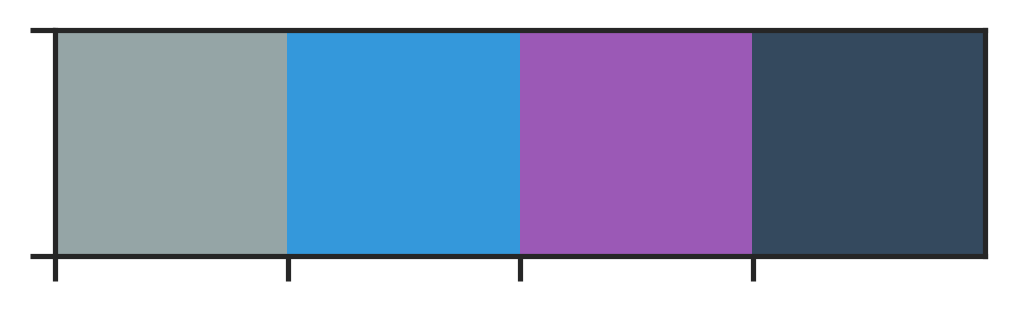

In [18]:
flatui = ["#95a5a6", "#3498db", "#9b59b6",  "#34495e"]
sns.palplot(sns.color_palette(flatui))

In [19]:
d_feat_columns = X_train.columns.to_list()
d_feat_cat = [x.split('_', 1)[0] for x in d_feat_columns]
d_feat_name = [x.split('_', 1)[1] for x in d_feat_columns]
d_feat_cat_series = pd.Series(d_feat_cat)
d_feat_cat_series_capital = d_feat_cat_series.map(
    {'protein':'Protein'})
d_feat_cat_color = d_feat_cat_series.map(
    {'protein':'#9b59b6'})

d_feat_cat_pd = pd.DataFrame(data={'ori_name':d_feat_columns,
                                   'feat_name':d_feat_name,
                                  'cat_name':d_feat_cat,
                                  'cat_name_captical':d_feat_cat_series_capital.values,
                                  'cat_color':d_feat_cat_color.values})

In [20]:
print(d_feat_cat_pd.shape)
d_feat_cat_pd.head()

(98, 5)


,ori_name,feat_name,cat_name,cat_name_captical,cat_color
0,protein_AHSP,AHSP,protein,Protein,#9b59b6
1,protein_ALB,ALB,protein,Protein,#9b59b6
2,protein_ANG,ANG,protein,Protein,#9b59b6
3,protein_APOA1,APOA1,protein,Protein,#9b59b6
4,protein_APOA2,APOA2,protein,Protein,#9b59b6


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


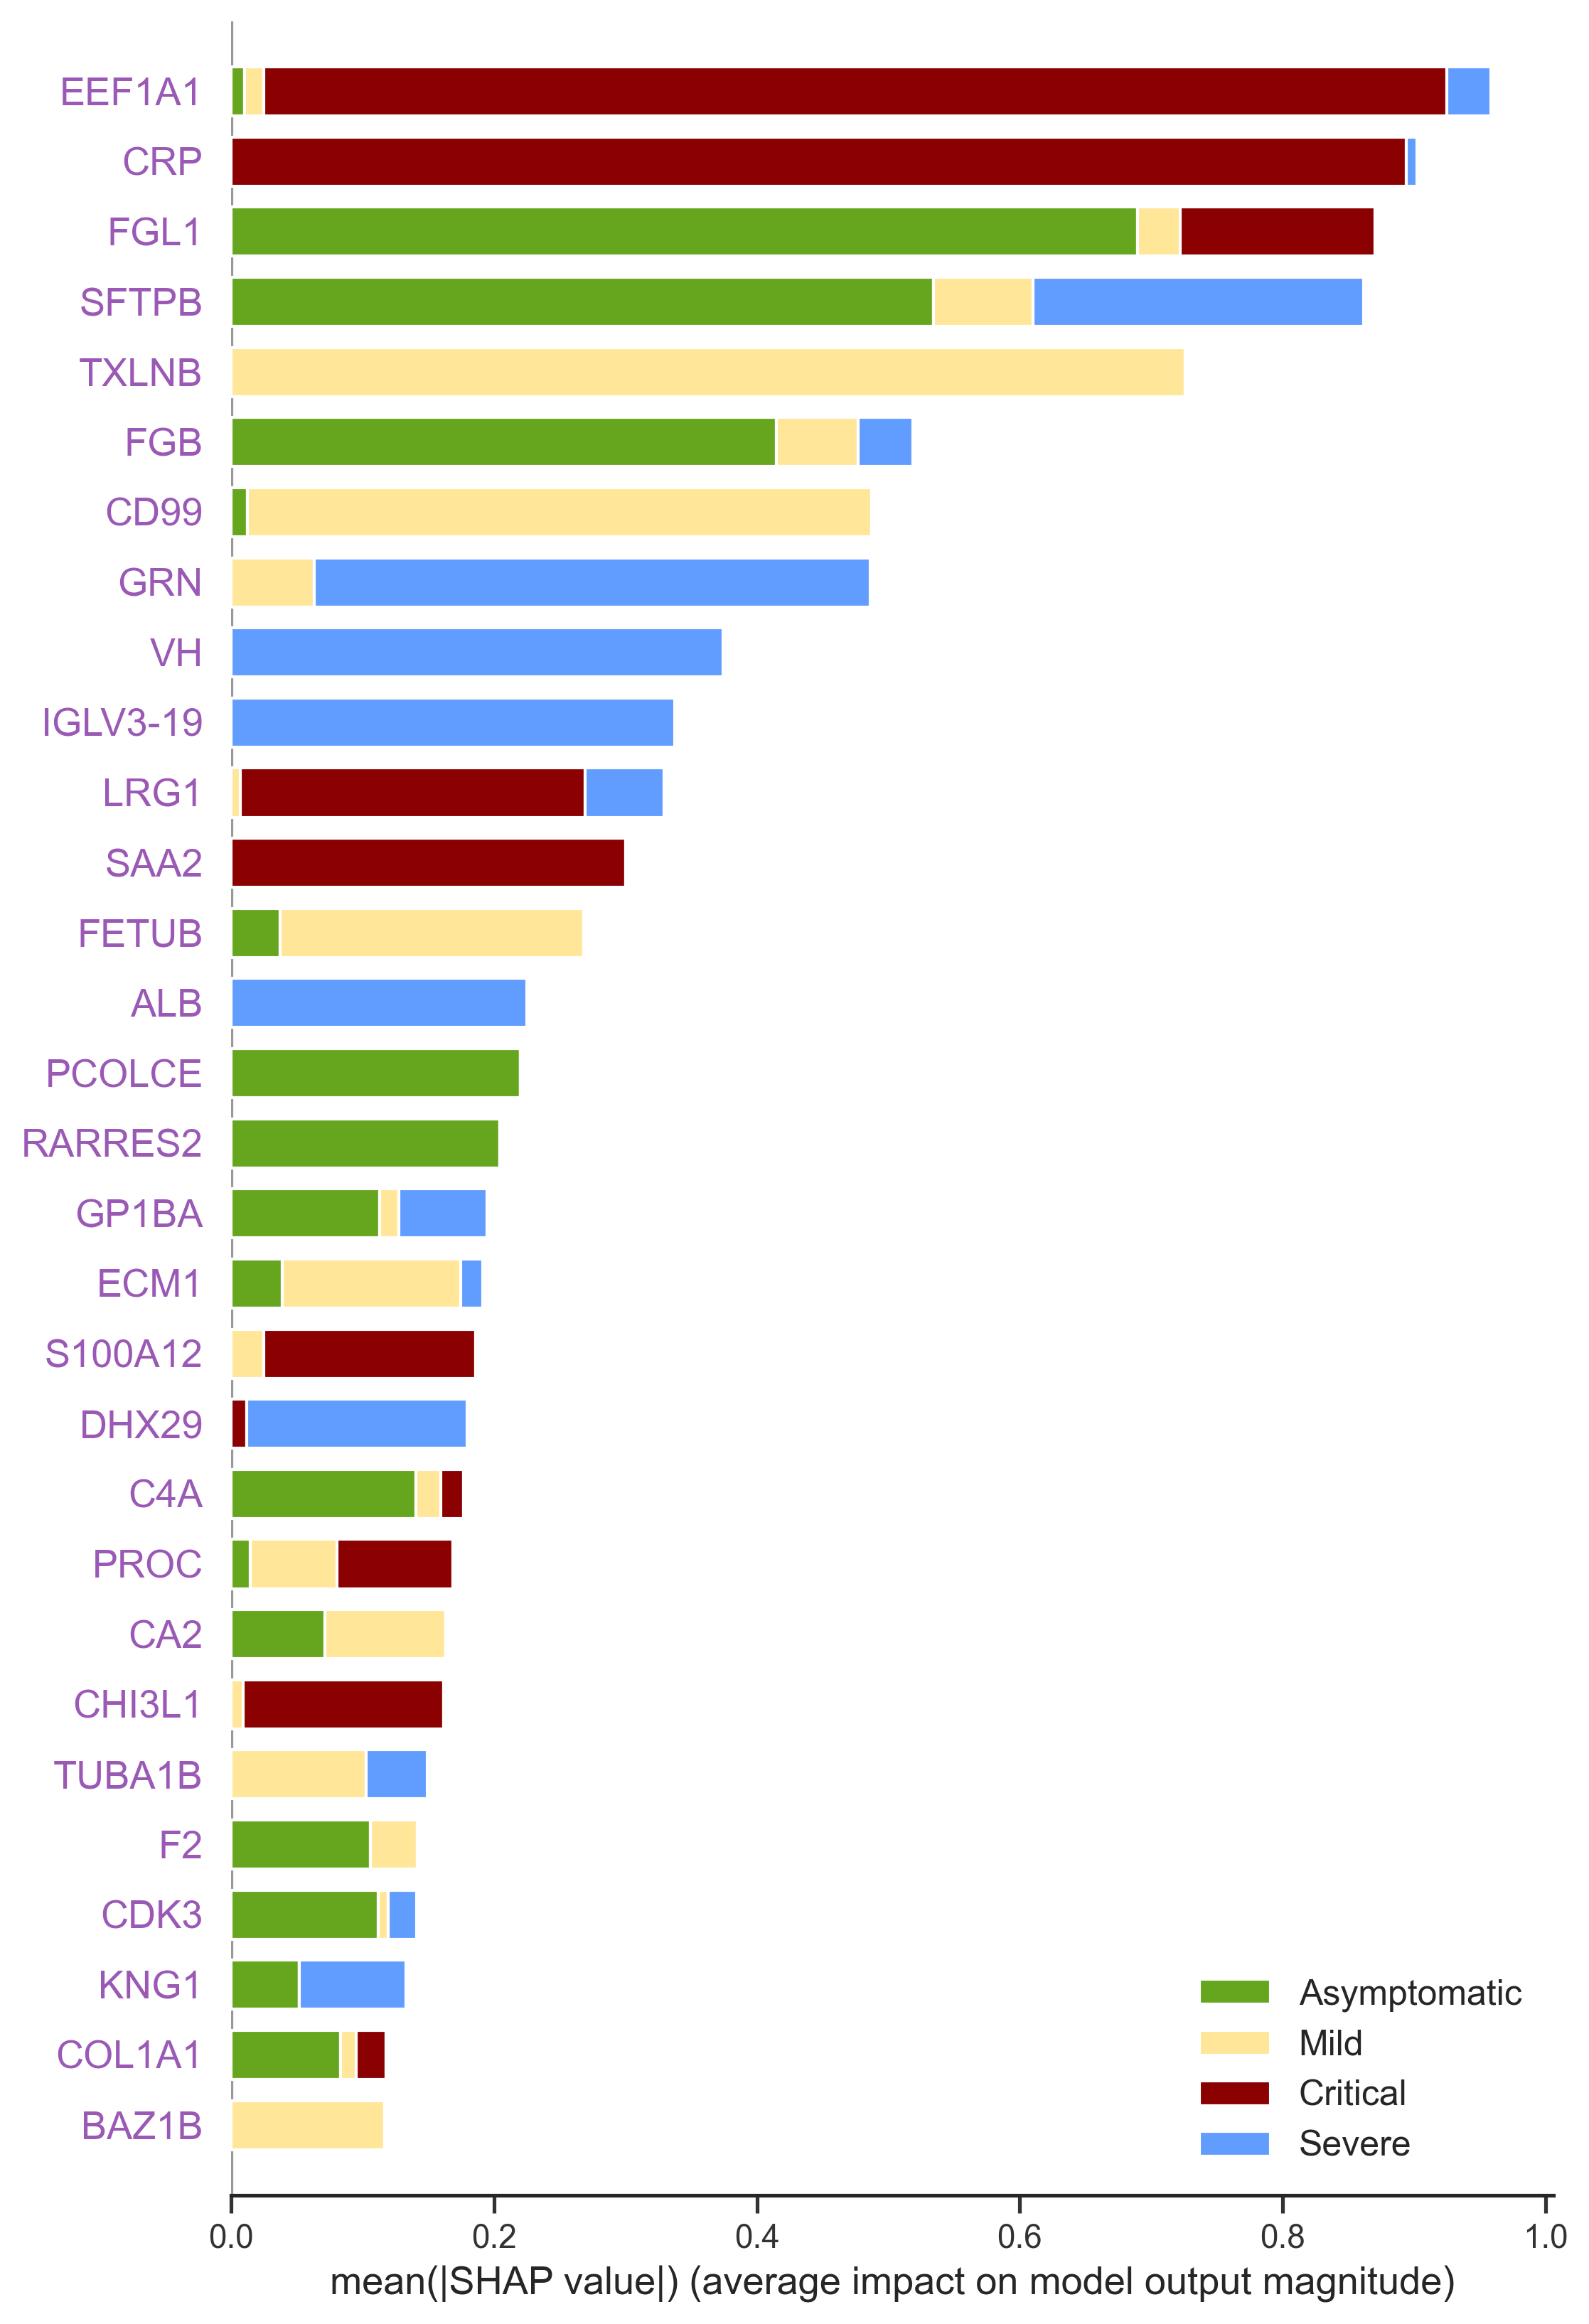

In [21]:
import shap
import re
from matplotlib import colors
class_names = ['Asymptomatic','Mild', 'Severe', 'Critical']
top_feat = 30
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train) # same to x

colorss = ["#66A61E", "#FFE699", "#619CFF", "darkred"]

# get class ordering from shap values
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])

# create listed colormap
cmap = colors.ListedColormap(np.array(colorss)[class_inds])

shap.summary_plot(shap_values, X_train.values, show=False, feature_names=d_feat_name, max_display=top_feat, 
                  class_names=class_names,color=cmap)
# plt.xlabel("SHAP value")

# y ticklables color
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num = -1
for lbl in xlbls:
    lbl.set_color(d_feat_cat_pd.loc[d_feat_cat_pd['feat_name']==lbl.get_text(), 'cat_color'].values[0])


In [22]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.reset_index(drop=True,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
0,protein_EEF1A1,25.877644
1,protein_CRP,24.355143
2,protein_FGL1,23.503088
3,protein_SFTPB,23.257240
4,protein_TXLNB,19.591621


In [23]:
feature_importance_sel = feature_importance.loc[:top_feat-1].copy()
feature_importance_sel['omics_type'] = feature_importance_sel['col_name'].str.split('_').str[0]
feature_importance_sel['omics_type'].value_counts()

protein    30
Name: omics_type, dtype: int64

In [24]:
top_feat_names = feature_importance['col_name'].values[:top_feat]


In [25]:
# norm_test_lipid_df=pd.read_csv('f_data/norm_test_lipid_df_27.csv', sep='\t')
# norm_test_metabolic_df=pd.read_csv('f_data/norm_test_metabolic_df_27.csv', sep='\t')
norm_test_protein_df=pd.read_csv('f_data/norm_test_protein_df_27.csv', sep='\t')
# norm_test_mrna_df=pd.read_csv('f_data/norm_test_mrna_df_27.csv', sep='\t')

y_test = norm_test_protein_df['label_trans']
X_test_top = norm_test_protein_df[top_feat_names]

In [26]:
X_train_top = X_train[top_feat_names]
top_x_df = pd.concat([X_train_top,X_test_top]).reset_index(drop=True)
y=pd.concat([y_train,y_test]).reset_index(drop=True)

# Train with different number of features

In [27]:
# np.savez('t_sne_embedding.npz', x=X_embedded, y=y_symb )

In [28]:
# I agree, apparently markers only accepts these markers in scatterplot:
# filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# https://matplotlib.org/2.0.2/api/markers_api.html
def plot_umap(x_df, y_series,out_file=None):
    
    import umap
    markers = ('d','o','^','X')
#     palette = dict({'Asymptomatic':"#66A61E", 'Mild':"#FFE699", 'Severe':"#619CFF", 'Critical':"darkred"})
    # palette = ["#66A61E", "#FFE699", "#619CFF", "darkred"]
    palette = dict({'Asymptomatic':"#5cb85c", 'Mild':"#337ab7", 'Severe':"#f0ad4e", 'Critical':"#d9534f"})
    
    # ["#5cb85c", "#337ab7", "#f0ad4e", "darkred"]

    umap_ = umap.UMAP(n_neighbors=10,min_dist=0.5, random_state=123, metric='manhattan')  
    
    # min_dist=0.25,123,1233, correlation, euclidean
    umap_embedding = umap_.fit_transform(x_df)
    y_symb = y_series.map({0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'})
    sns.scatterplot(umap_embedding[:,0], umap_embedding[:,1], 
                    markers=markers,hue=y_symb.values,style=y_symb.values,
                    palette=palette,legend='full',s=100) # style=y_symb.values
    plt.xlabel('UMAP_1')
    plt.ylabel('UMAP_2')
    plt.legend(loc="best")
    sns.despine()

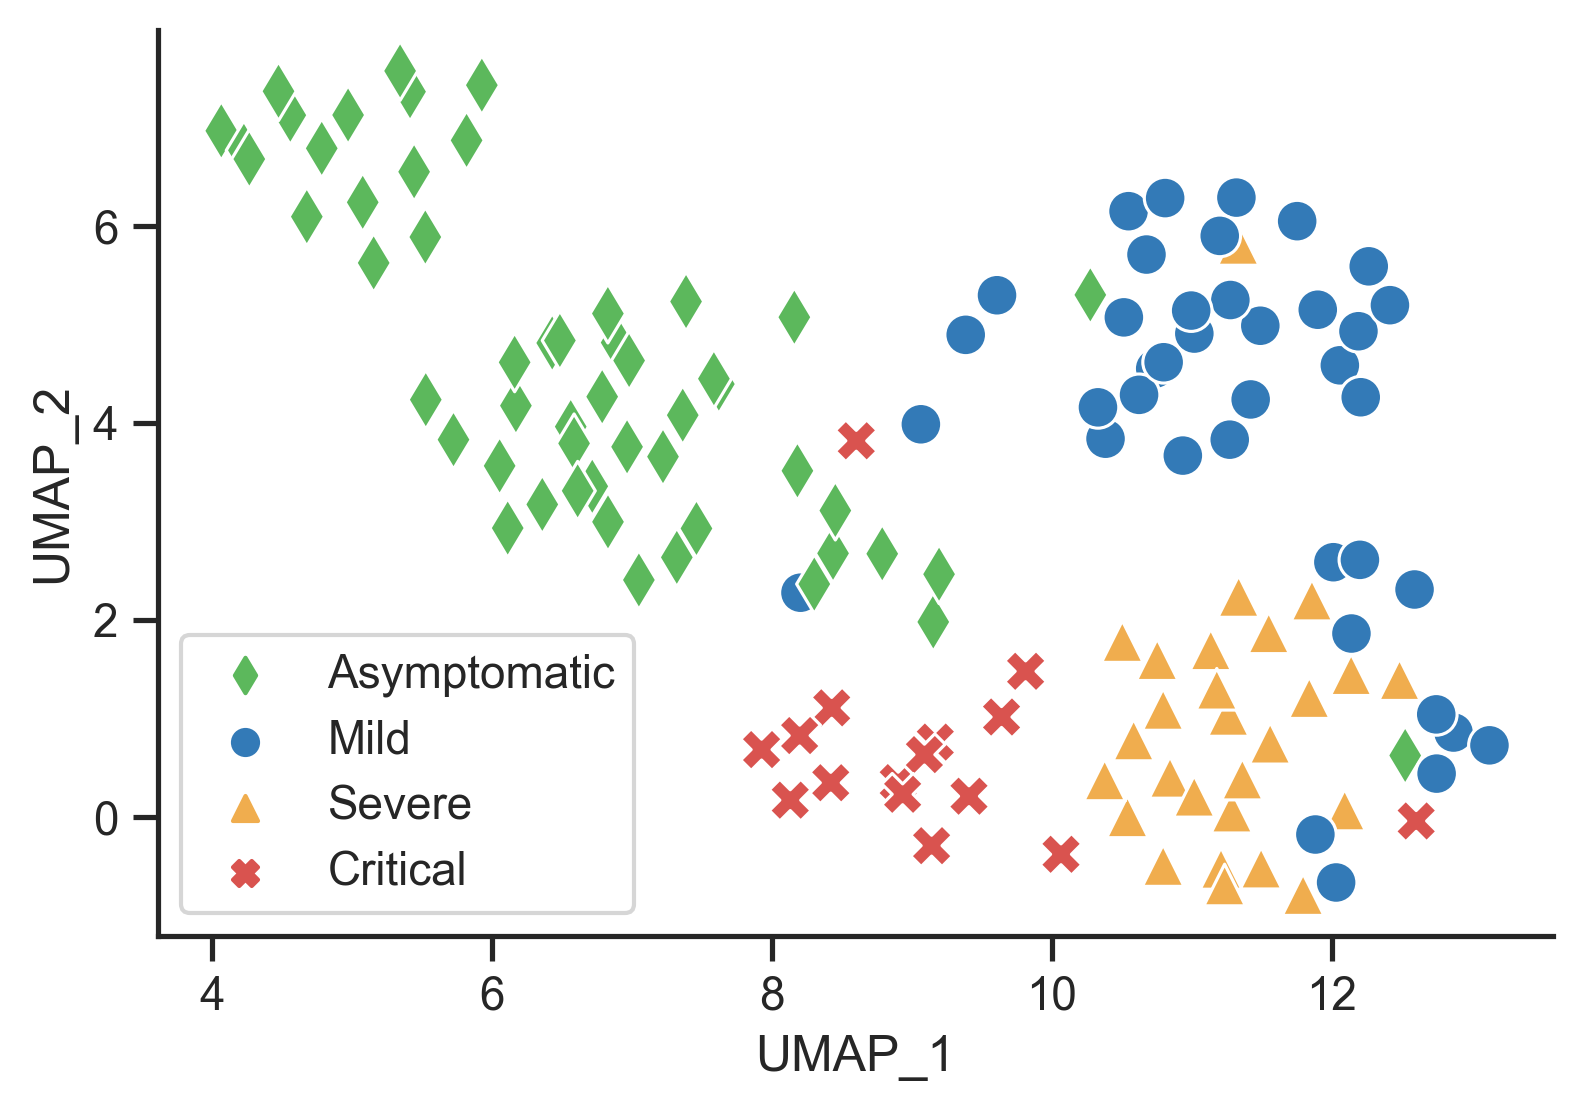

In [29]:
plot_umap(top_x_df,y)
plt.savefig("f_result/fs_umap_protein.pdf", bbox_inches='tight', pad_inches = 0.1)

In [30]:
# np.savez('umap_embedding.npz', x=umap_embedding, y=y_symb )

In [31]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

top_feature_samples=top_x_df.copy()
top_feature_samples['Label']=y
top_feature_samples.sort_values(by='Label',inplace=True)
top_feature_samples.reset_index(drop=True, inplace=True)
y_top_sample = top_feature_samples['Label']
x_top_sample = top_feature_samples.drop(columns=['Label'])

x_top_sample.rename(columns = dict(zip(x_top_sample.columns.to_list(), 
                                       [x.split('_',1)[1] for x in x_top_sample.columns.to_list()])), inplace=True)


# x_top_sample_corr = x_top_sample.T.corr()
# x_top_sample_dism = 1 - x_top_sample_corr   # distance matrix
# linkage = hc.linkage(sp.distance.squareform(x_top_sample_dism), method='average')

# # https://python-graph-gallery.com/402-color-dendrogram-labels/
# linkage2 = hc.linkage(x_top_sample, 'ward')


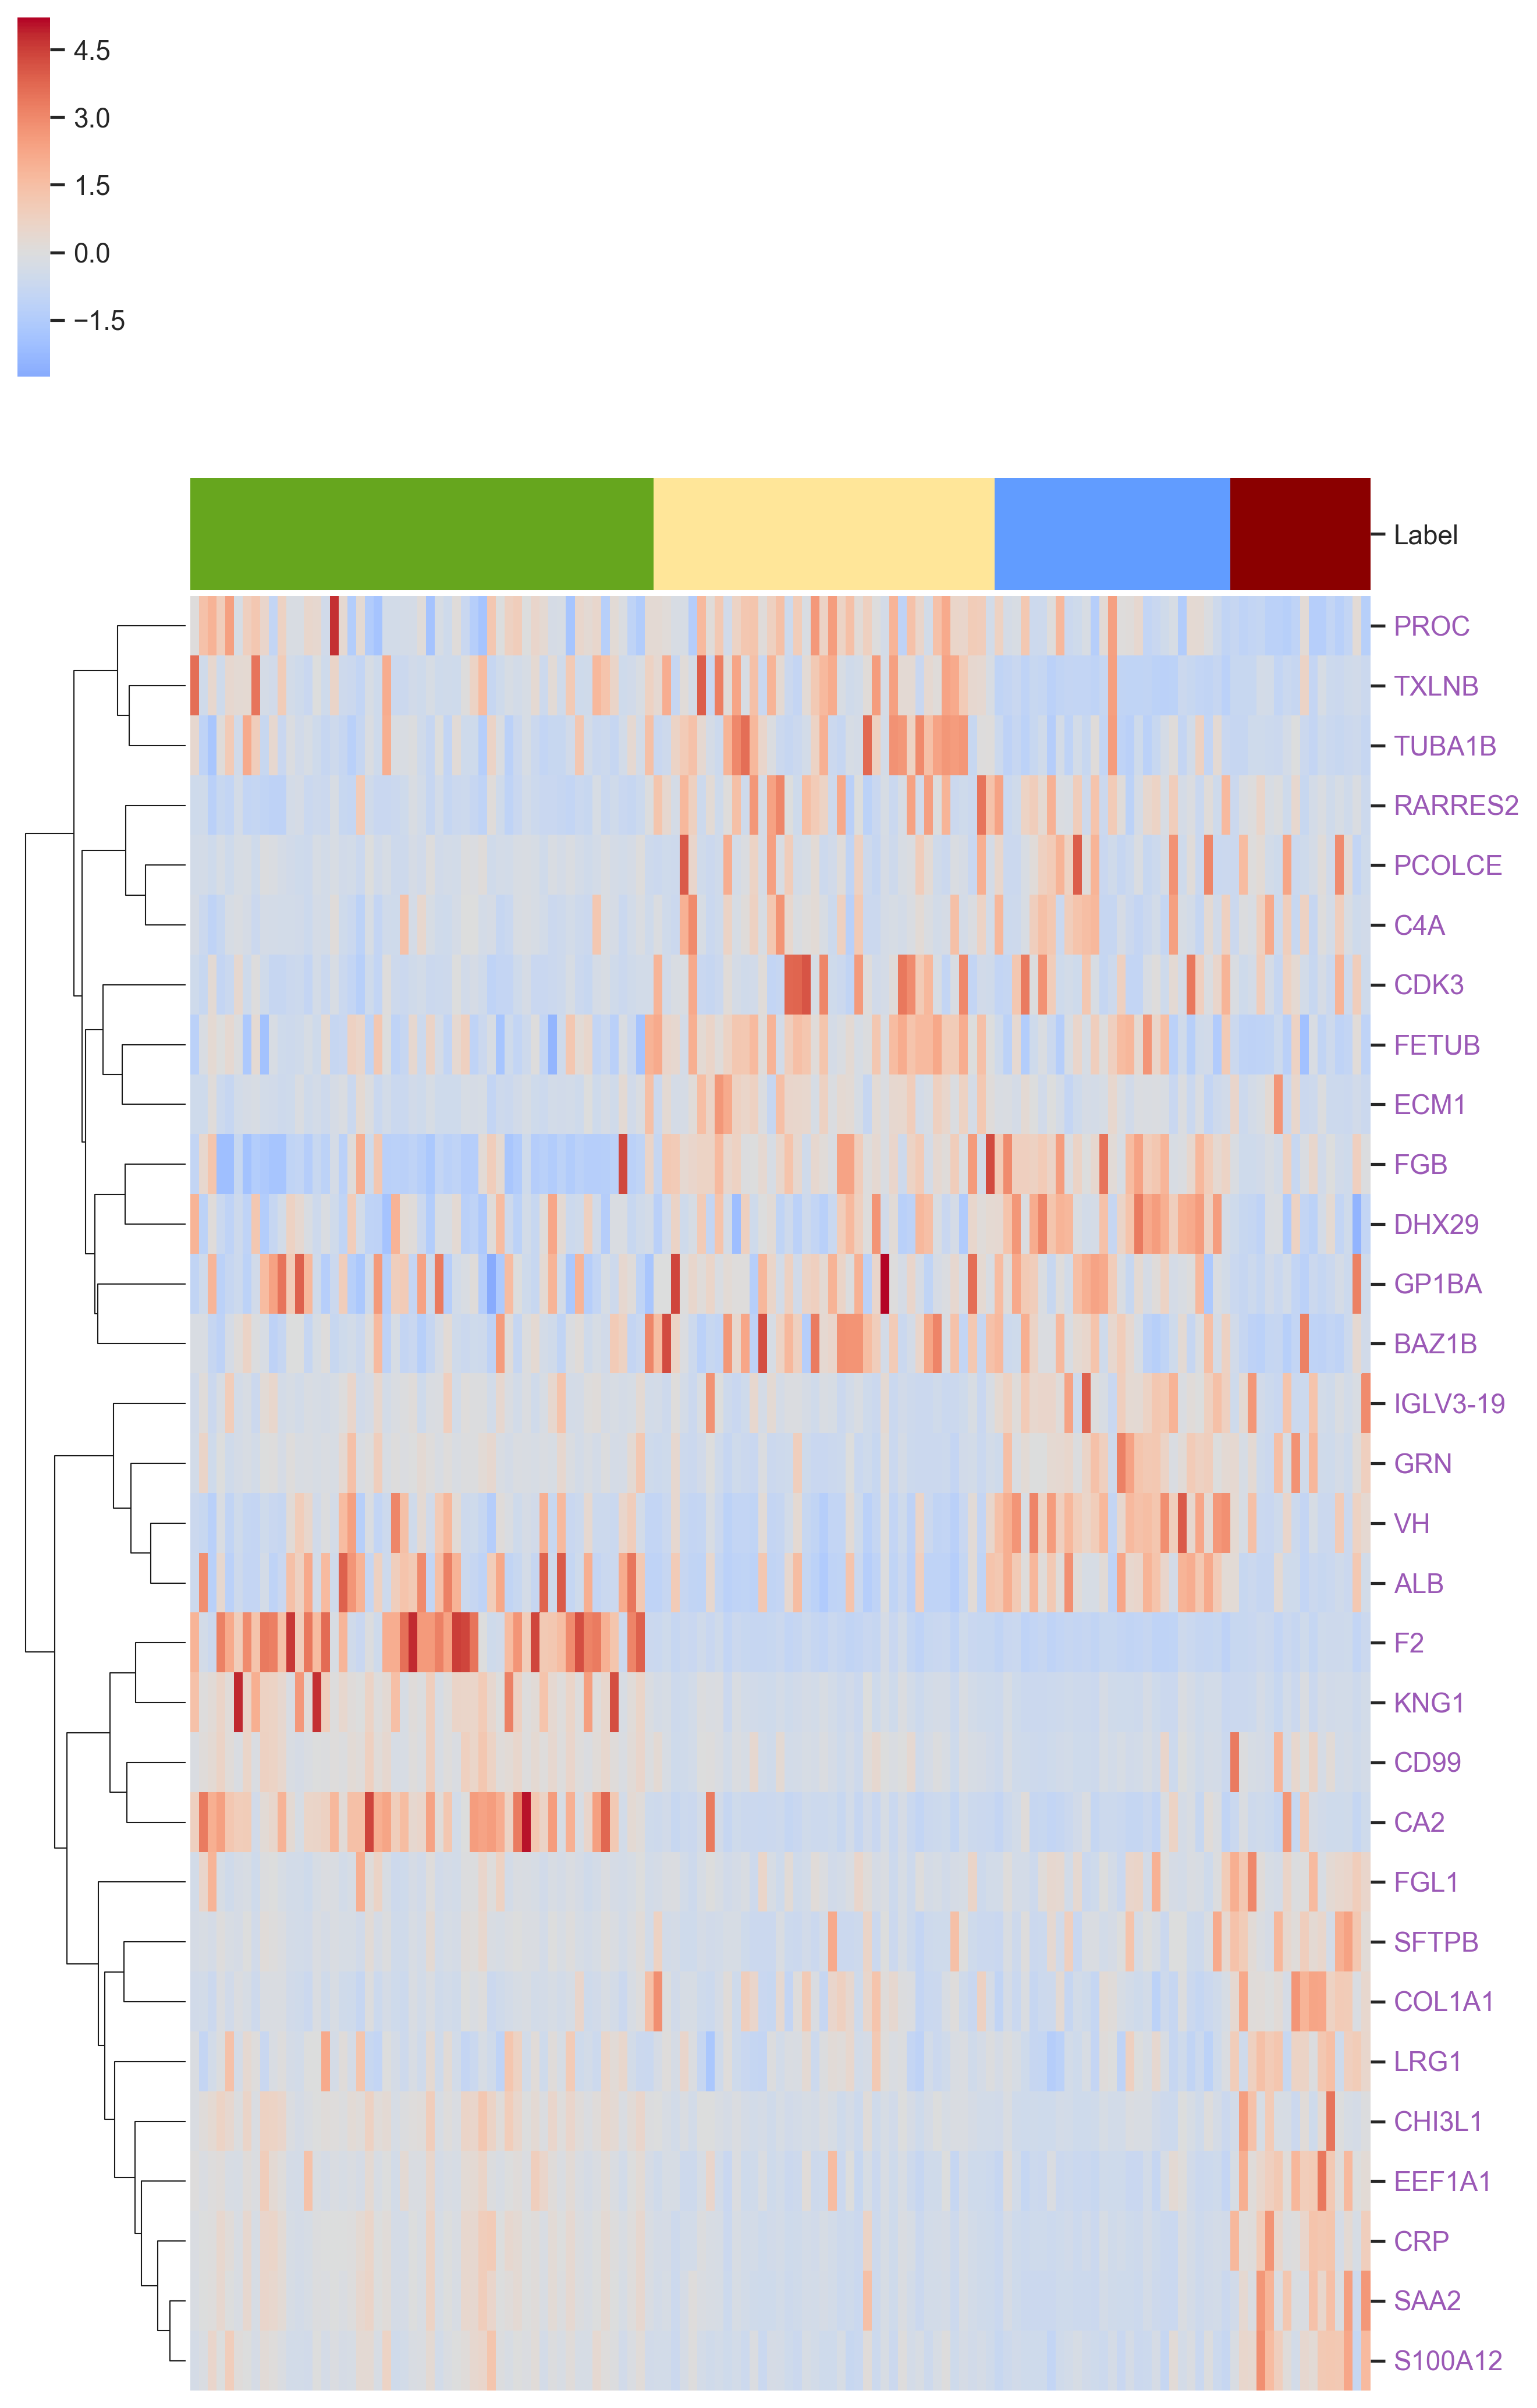

In [32]:
# fig, ax = plt.subplots(figsize=(11.7/1.2,12))
y_symb = y_top_sample.map({0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'})
lut = dict(zip(y_symb.unique(), ["#66A61E", "#FFE699", "#619CFF", "darkred"]))
col_colors = y_symb.map(lut)
g = sns.clustermap(x_top_sample.T, col_colors=col_colors, cmap=plt.get_cmap("coolwarm"),figsize=(10, 18), center=0.0,
                   row_cluster=True, col_cluster=False, metric="correlation", method='complete',z_score=1,
                   xticklabels=False) 
#metric="correlation", col_linkage=linkage, col_colors=col_colors,cmap=sns.color_palette("coolwarm"),z_score=1,robust=True,method='complete'
xlbls = g.ax_heatmap.yaxis.get_majorticklabels()
num = -1
for lbl in xlbls:
    lbl.set_color(d_feat_cat_pd.loc[d_feat_cat_pd['feat_name']==lbl.get_text(), 'cat_color'].values[0])


In [33]:
mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc, mean_precision, std_precision, mean_recalls, mean_ap, std_ap= roc_pr_cv(
    best_params, X_train[top_feat_names], y_train, iteration=100, random_state=None)

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# retrain the model with top k features
best_xgb = xgb.XGBClassifier(**best_params)
weight_class_dict = get_class_weight(y_train)
ins_weight_lst = [weight_class_dict[i] for i in y_train.values]
best_xgb.fit(X_train_top, y_train.values, sample_weight=ins_weight_lst)

p_pred_prob=best_xgb.predict_proba(X_test_top)

classes=[0, 1, 2, 3]
y_val = label_binarize(y_test, classes=classes)
n_classes = len(classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

precision = dict()
recall = dict()
apr=dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], p_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],
                                                        p_pred_prob[:, i])
    apr[i] = average_precision_score(y_val[:, i], p_pred_prob[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), p_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# pr
precision['micro'], recall['micro'], _ = precision_recall_curve(y_val.ravel(), p_pred_prob.ravel())
apr['micro'] = average_precision_score(y_val, p_pred_prob, average="micro")


In [35]:
# save the test preformace
np.savez('f_data/single-protein_test_performance.npz', 
         fpr_micro=fpr["micro"], tpr_micro=tpr["micro"], auroc=roc_auc["micro"],
         prec_micro = precision['micro'], recall_micro=recall['micro'], auprc=apr['micro'])

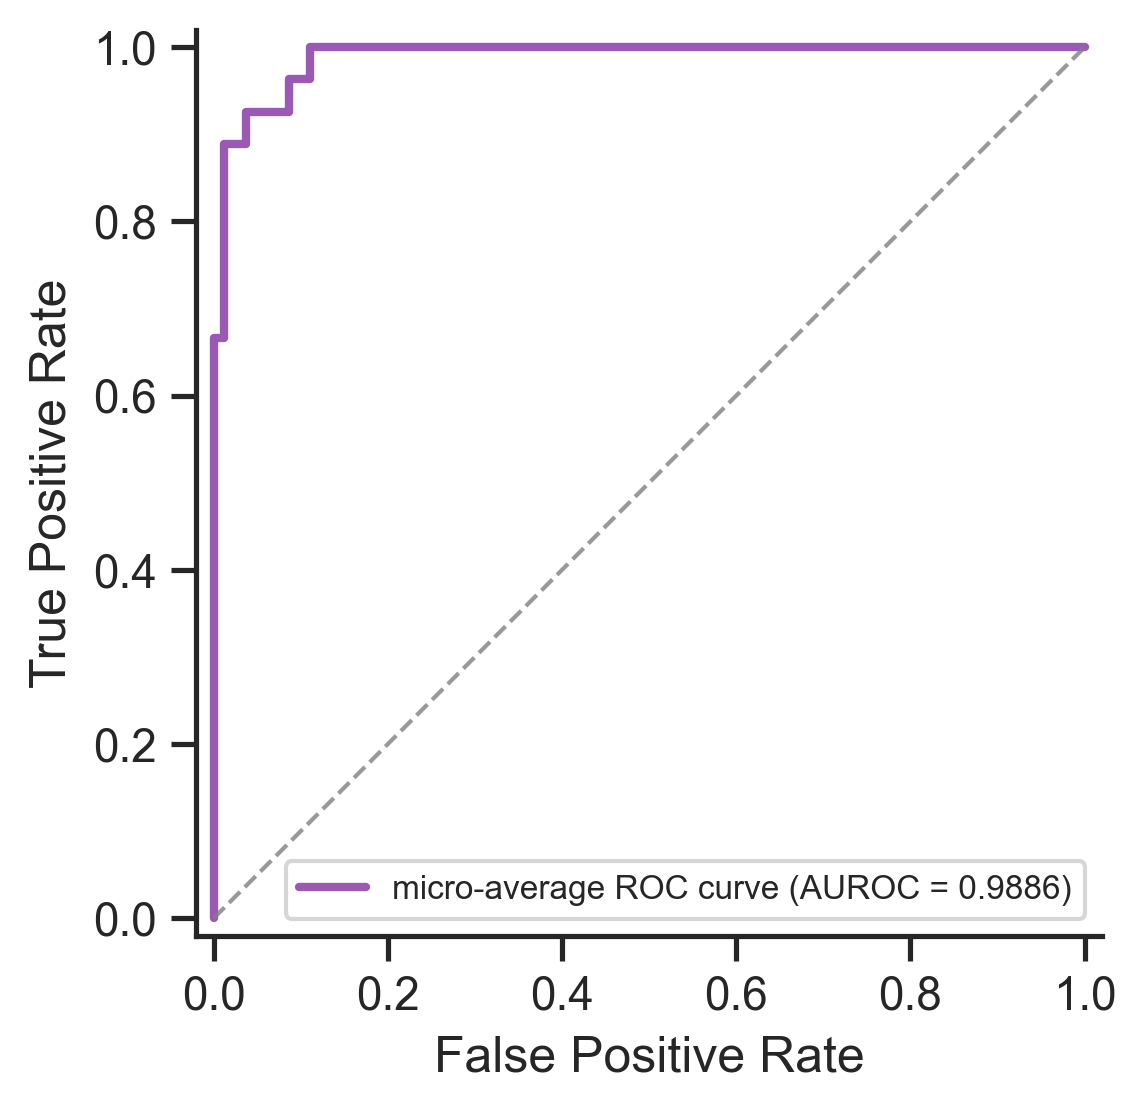

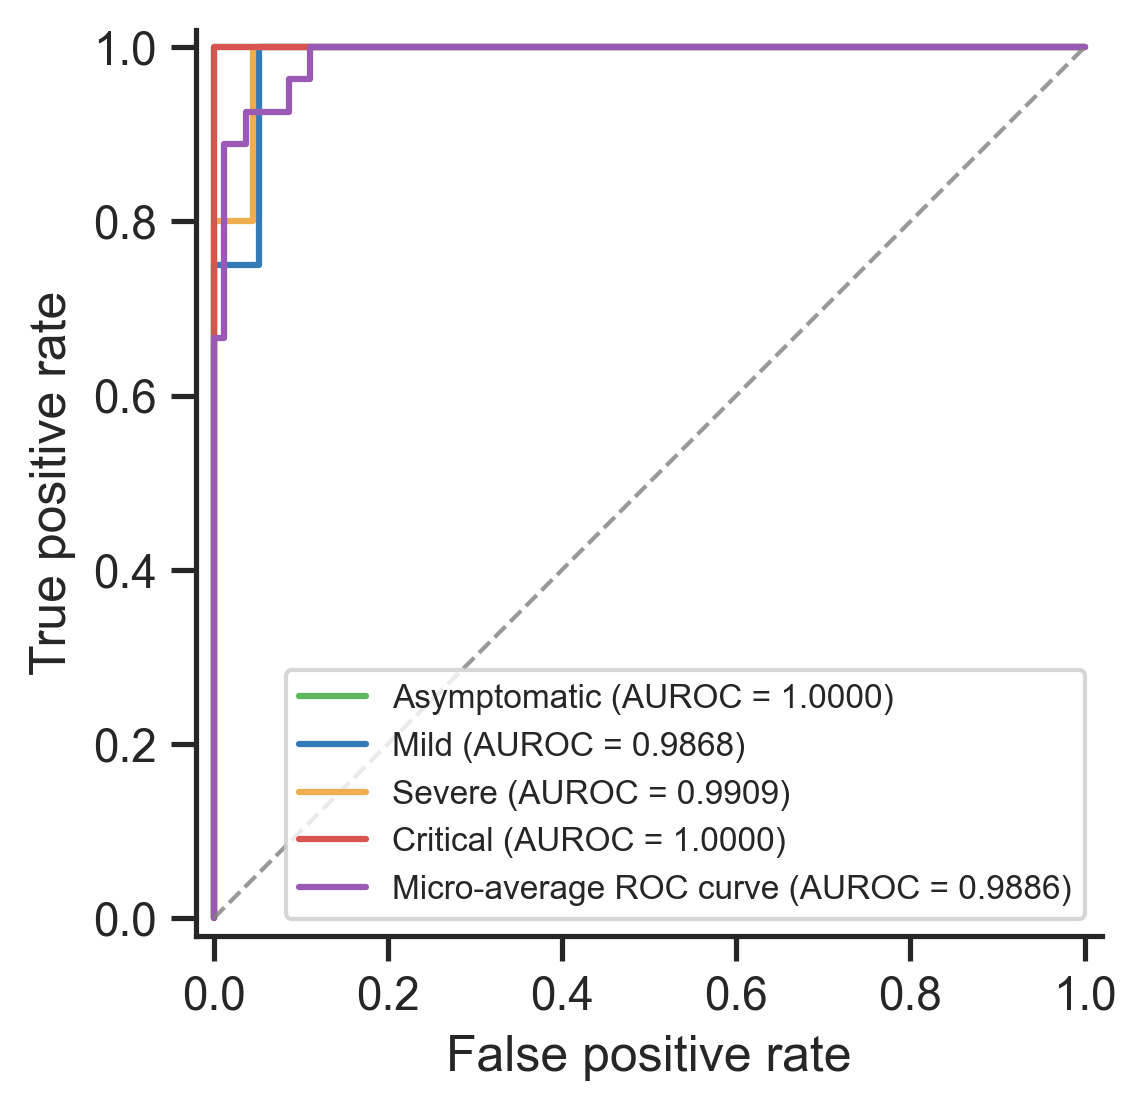

In [36]:
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (AUROC = %0.4f)' % roc_auc["micro"], 
         color='#9b59b6',lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Micro-average Receiver operating characteristic')
plt.gca().set_aspect('equal') 
plt.legend(loc="lower right",prop={'size': 8})
sns.despine()
plt.show()

# Plot ROC curve
class_lab = {0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'}
colorss = ["#5cb85c", "#337ab7", "#f0ad4e", "#d9534f"]
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colorss[i],
             label='{0} (AUROC = {1:0.4f})'
                                   ''.format(class_lab[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='#9b59b6',
         label='Micro-average ROC curve (AUROC = {0:0.4f})'
               ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('Receiver operating characteristic for all stage')
plt.legend(loc="lower right",prop={'size': 8})
plt.gca().set_aspect('equal') 
sns.despine()
plt.savefig("f_result/fs_test_roc_protein.pdf", bbox_inches='tight', pad_inches = 0.1)
plt.show()

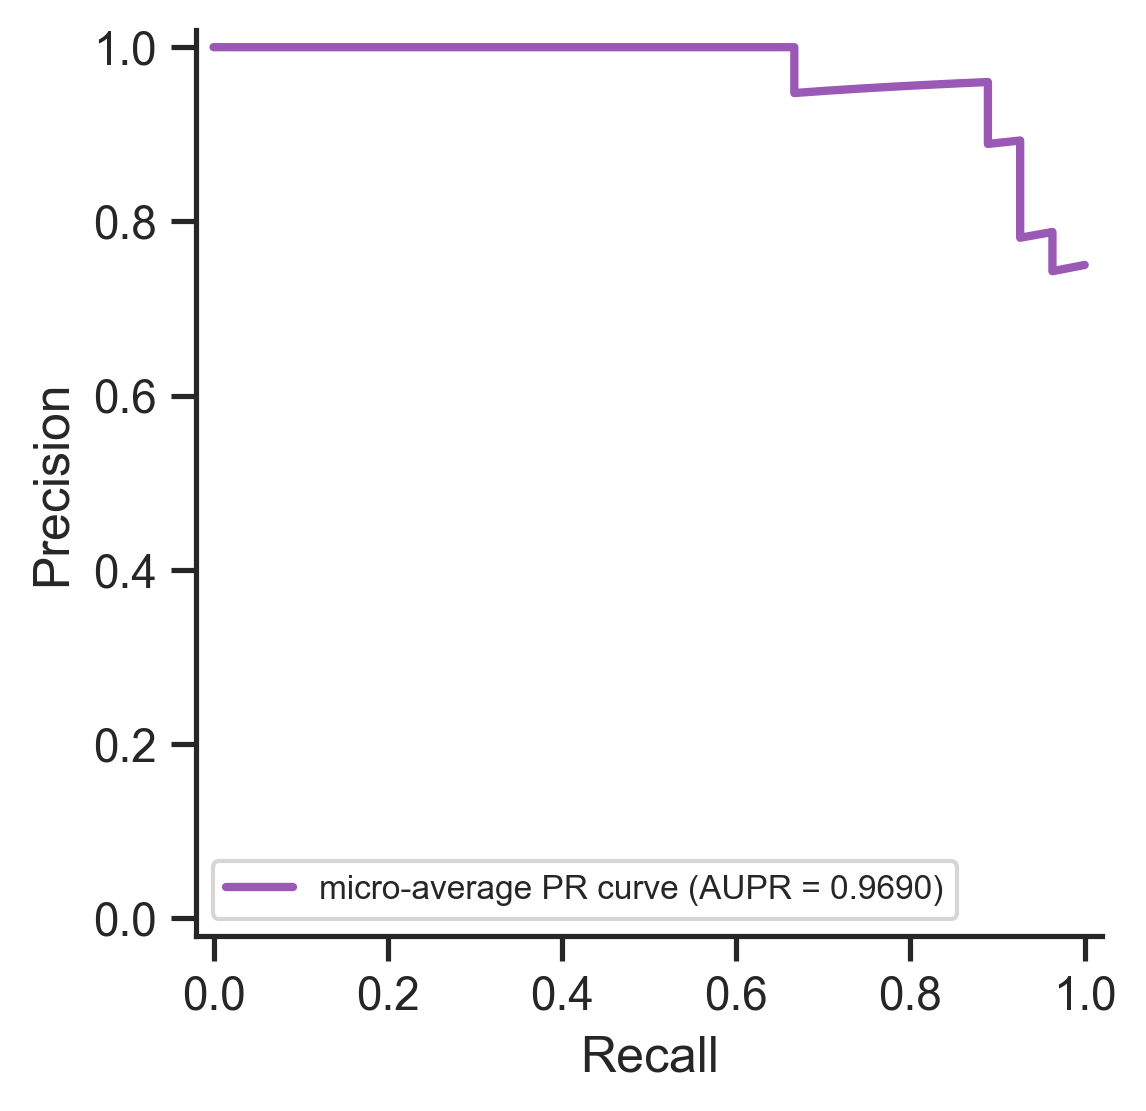

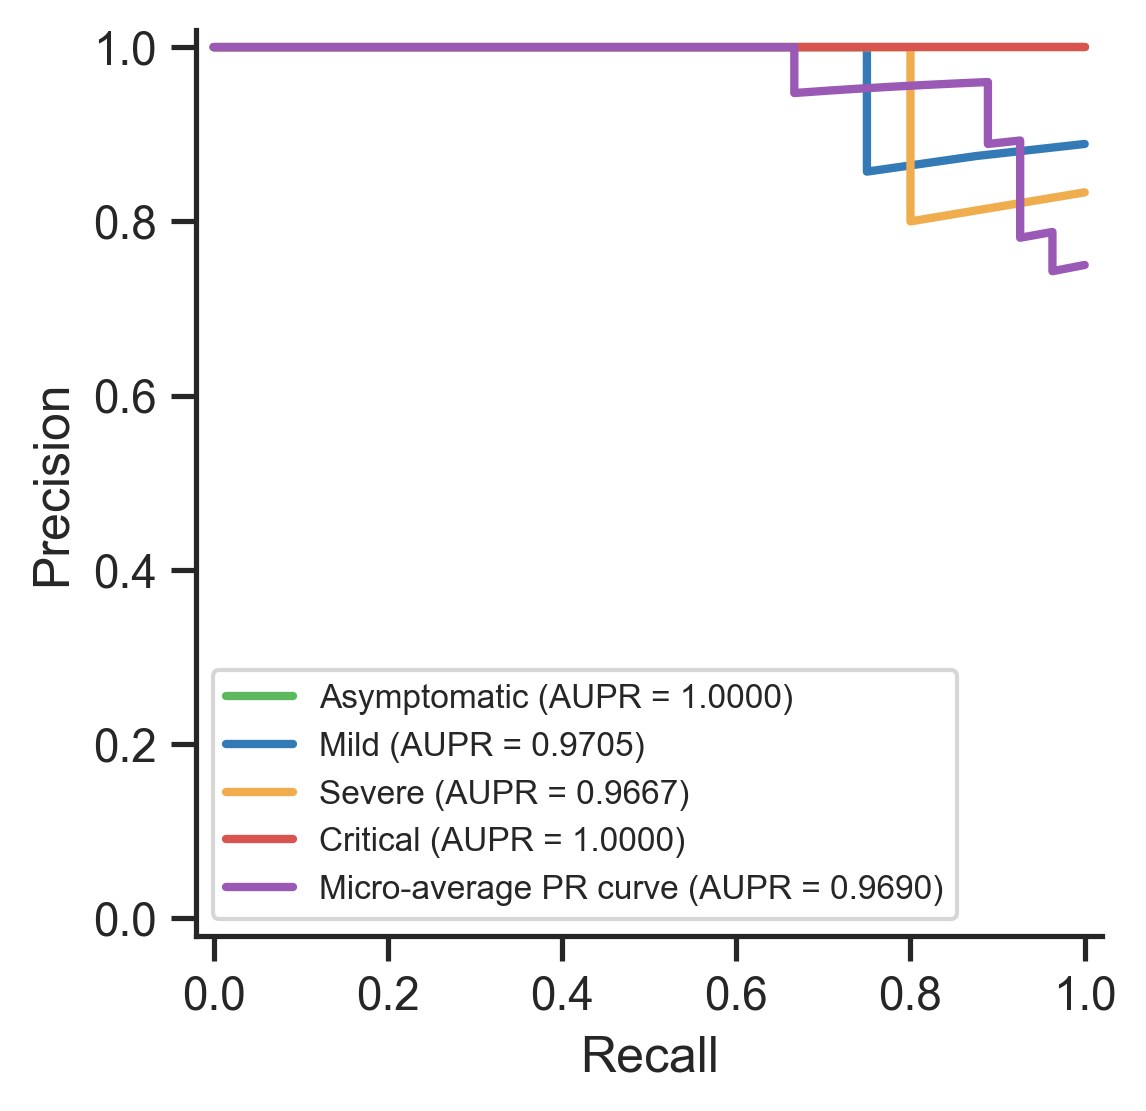

In [37]:
# plt.figure(figsize=(10, 8), dpi=300)
# plt.plot(np.concatenate(([1],recall["micro"])), np.concatenate(([0],precision["micro"])), 
#          label='micro-average PR curve (AUPR = %0.3f)' % apr["micro"], 
#          color='#34495e',lw=2)
plt.plot(recall["micro"], precision["micro"], 
         label='micro-average PR curve (AUPR = %0.4f)' % apr["micro"], 
         color='#9b59b6',lw=2)
# plt.plot([0, 1], [1, 0], 'r--', lw=2, alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Micro-average PR Curve')
plt.legend(loc="lower left",prop={'size': 8})
plt.gca().set_aspect('equal', adjustable='box') 
sns.despine()
plt.show()

# Plot ROC curve
plt.figure()
class_lab = {0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'}
colorss = ["#5cb85c", "#337ab7", "#f0ad4e", "#d9534f"]
for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colorss[i],lw=2,
             label='{0} (AUPR = {1:0.4f})'
             ''.format(class_lab[i], apr[i]))
    
plt.plot(recall["micro"],precision["micro"],color='#9b59b6',lw=2,
         label='Micro-average PR curve (AUPR = {0:0.4f})'
               ''.format(apr["micro"]))



# plt.plot([0, 1], [1, 0], 'r--', lw=2, alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('PR Curve for classes')
plt.legend(loc="best",prop={'size': 8})
plt.gca().set_aspect('equal', adjustable='box') 
sns.despine()
plt.savefig("f_result/fs_test_pr_protein.pdf", bbox_inches='tight', pad_inches = 0.1)
plt.show()

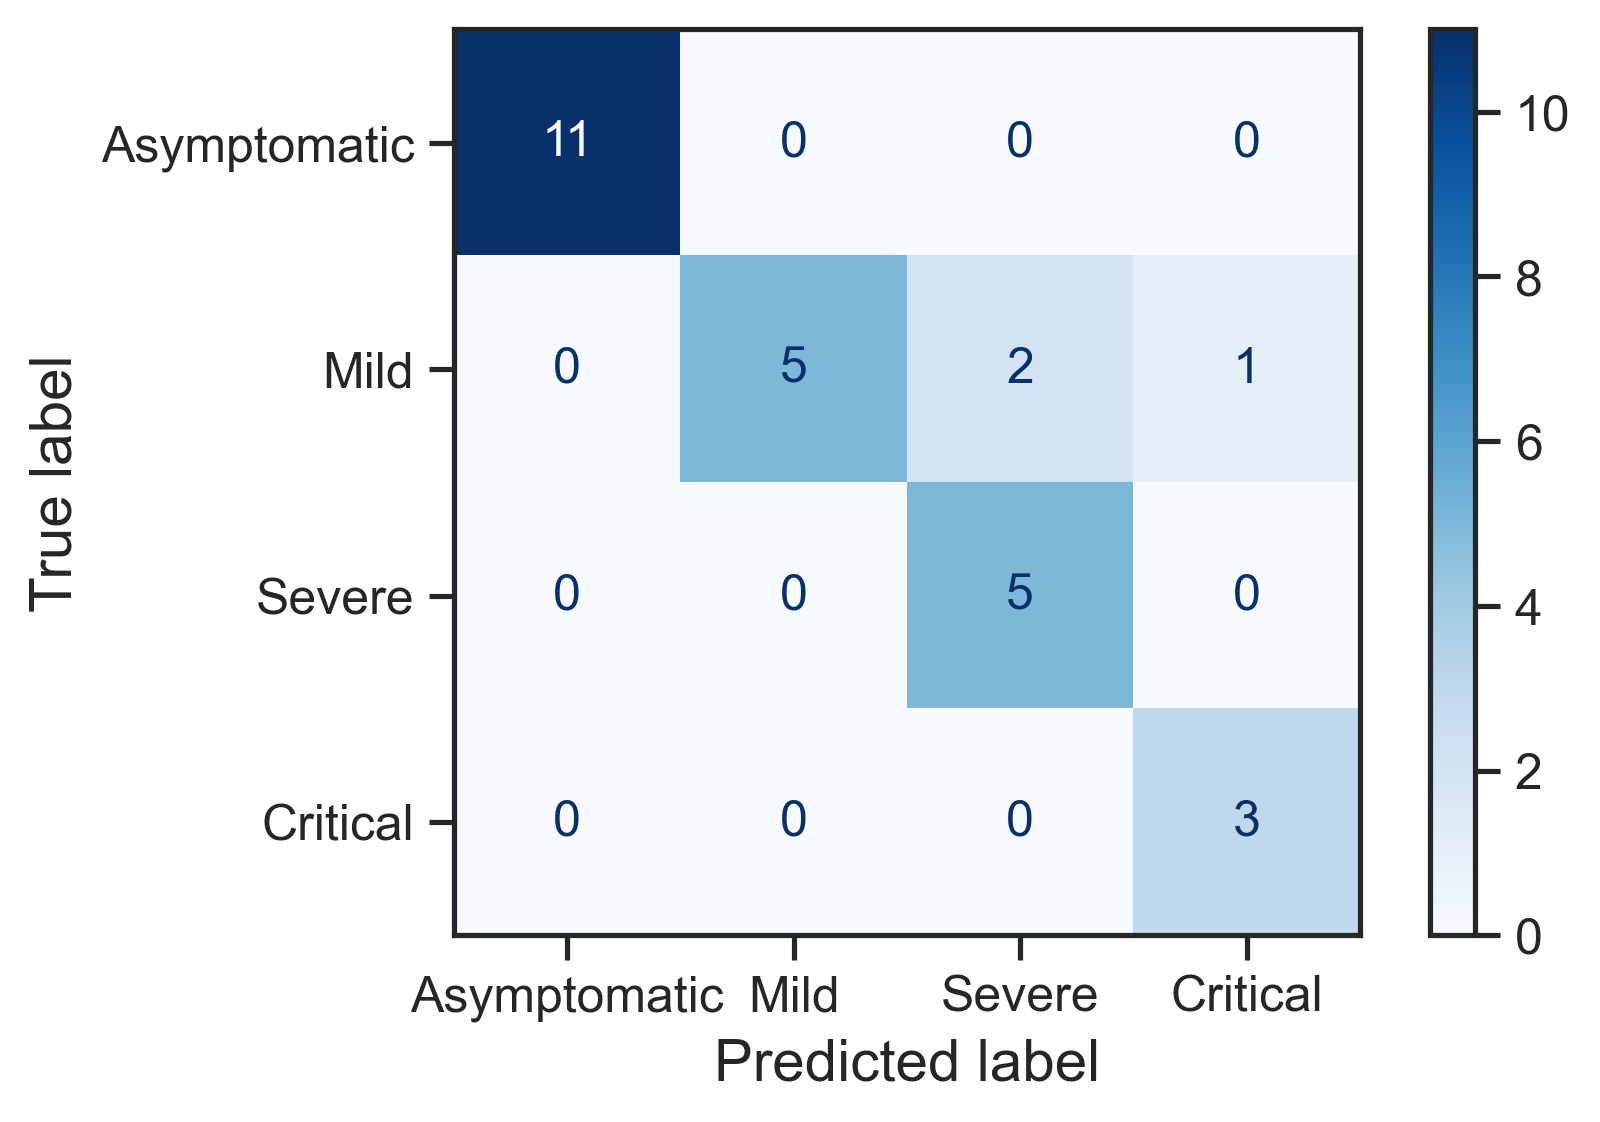

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

class_names = ['Asymptomatic', 'Mild', 'Severe', 'Critical']

x_in = X_test_top
plot_confusion_matrix(best_xgb,X_test_top, y_test.values,
                      display_labels=class_names, cmap=plt.cm.Blues, normalize=None)
plt.savefig("f_result/fs_cm_protein.pdf", bbox_inches='tight', pad_inches = 0.1)

In [ ]:
len(top_feat_names)

In [ ]:
from sklearn.metrics import classification_report
p_pred_l = np.argmax(p_pred_prob,axis=1)
print(classification_report(y_test.values, p_pred_l, target_names=class_names))